# Transformer from scratch


The Transformer is then tested on a simple seq2seq task : **translating sentences from English to French**.

[<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-21.png" width="300">](https://arxiv.org/abs/1706.03762)

**Steps :**
1. [Preparing the data](#Preparing-the-data)
2. [Building the Transformer](#Building-the-Transformer)
3. [Training the Transformer](#Training-the-Transformer)
4. [Testing the Transformer](#Testing-the-Transformer)
    


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import string
import re
import numpy as np
import string
from nltk.translate.bleu_score import sentence_bleu

In [3]:
print(f"Tensor Flow Version: {tf.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "AVAILABLE" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.15.0

GPU is AVAILABLE


# Preparing the data

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Reading the data</b></p>
</div>

In [4]:
df=pd.read_csv("./drive/MyDrive/eng_-french.csv")

df['source'] = df['English words/sentences']

# let's add an initial “seed” token ([start]) and a stop token ([end]) to each target sentence.
df['target'] = df['French words/sentences'].apply(lambda x: '[start] ' + x + ' [end]')
df = df.drop(['English words/sentences', 'French words/sentences'], axis=1)

# display a few random samples
df.sample(5)

,source,target
56508,Show us what you bought.,[start] Montrez-nous ce que vous avez acheté. ...
56550,Stay out of my business.,[start] Restez en dehors de mes affaires ! [end]
6567,This is sweet.,[start] C'est gentil. [end]
48731,I'm kind of sick today.,[start] Je suis un peu malade aujourd'hui. [end]
142824,Where did you put the television guide?,[start] Où as-tu mis le programme de télévisio...


<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Shuffling the data and splitting it into train, validation, and test sets</b></p>
</div>

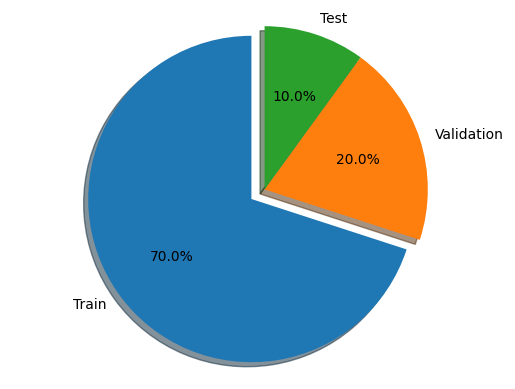

In [5]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

# split the data into train, validation, and test sets
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.2)
test_size = int(len(df) * 0.1)

train_df = df[:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df[train_size+val_size:]

# display the data sets representations using a pie chart just to see the distribution of the data
labels = 'Train', 'Validation', 'Test'
sizes = [len(train_df), len(val_df), len(test_df)]
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()


<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Standardizing, tokenizing and indexing the data</b></p>
</div>

In [6]:
max_tokens = 25000
sequence_length = 30

# define a custom standardization function that convert to lowercase and strips all punctuations except "[" and "]" (so we can tell apart "start" from "[start]").
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

# tokenize the data using our custom standardization function
source_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length + 1, # add +1 token to our target sentences since they'll be shifted right by 1 during training
    standardize=custom_standardization,
)

# index all tokens in the source and target sentences
train_source_texts = train_df['source'].values
train_target_texts = train_df['target'].values
source_vectorization.adapt(train_source_texts)
target_vectorization.adapt(train_target_texts)

In [7]:
# display a random sample before and after vectorization just to test the vectorization
random_sample = random.randint(0, len(train_df))
print("Source texts (one random sample):", train_source_texts[random_sample])
print("Target texts (one random sample):", train_target_texts[random_sample])
print("Source vectors (one random sample):", source_vectorization(train_source_texts[random_sample]))
print("Target vectors (one random sample):", target_vectorization(train_target_texts[random_sample]))

# display the decoding of the vectorized text (from vector back to text) just to test the vectorization
source_decoded_text = ''
for i in range(len(source_vectorization(train_source_texts[random_sample]))):
    source_decoded_text += source_vectorization.get_vocabulary()[source_vectorization(train_source_texts[random_sample])[i]] + ' '
print("Source decoded texts (one random sample):", source_decoded_text)

target_decoded_text = ''
for i in range(len(target_vectorization(train_target_texts[random_sample]))):
    target_decoded_text += target_vectorization.get_vocabulary()[target_vectorization(train_target_texts[random_sample])[i]] + ' '
print("Target decoded texts (one random sample):", target_decoded_text)

Source texts (one random sample): You don't look like a millionaire.
Target texts (one random sample): [start] Vous n'avez pas l'air d'un millionnaire. [end]
Source vectors (one random sample): tf.Tensor(
[   3   18  123   32    6 2938    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(30,), dtype=int64)
Target vectors (one random sample): tf.Tensor(
[   2   12  520    6  146  177 4274    3    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0], shape=(31,), dtype=int64)
Source decoded texts (one random sample): you dont look like a millionaire                         
Target decoded texts (one random sample): [start] vous navez pas lair dun millionnaire [end]                        


In [8]:
# display the shape of our vectorized data
train_source_vectors = source_vectorization(train_source_texts)
train_target_vectors = target_vectorization(train_target_texts)
print("Source vectors (shape):", train_source_vectors.shape)
print("Target vectors (shape):", train_target_vectors.shape)

Source vectors (shape): (122934, 30)
Target vectors (shape): (122934, 31)


# Building the Transformer

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Positional Embedding</b></p>
</div>

In [9]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim) # token embedding layer
        self.position_embeddings = tf.keras.layers.Embedding(input_dim=sequence_length, output_dim=output_dim) # position embedding layer
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        embedded_tokens = self.token_embeddings(inputs) # embed the tokens
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1) # create the positional information
        embedded_positions = self.position_embeddings(positions) # embed the positions
        return embedded_tokens + embedded_positions # add the token and position embeddings to create the positional embeddings

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
        })
        return config

In [10]:
# display a random sample before and after embbeding just to test our class

embed_dim = 256

train_source_embedded = PositionalEmbedding(
    sequence_length=sequence_length,
    input_dim=max_tokens,
    output_dim=embed_dim,
    name="source_embedding",
) (train_source_vectors)

train_target_embedded = PositionalEmbedding(
    sequence_length=sequence_length,
    input_dim=max_tokens,
    output_dim=embed_dim,
    name="target_embedding",
) (train_source_vectors)

random_sample = random.randint(0, len(train_df))
print("Source texts (one random sample):", train_source_texts[random_sample])
print("Target texts (one random sample):", train_target_texts[random_sample])
print("Source vectors (one random sample):", source_vectorization(train_source_texts[random_sample]))
print("Target vectors (one random sample):", target_vectorization(train_target_texts[random_sample]))
print("Source embedded vectors (one random sample):", train_source_embedded[random_sample])
print("Target embedded vectors (one random sample):", train_target_embedded[random_sample])

Source texts (one random sample): I didn't realize you were serious.
Target texts (one random sample): [start] Je n'ai pas pris conscience que vous étiez sérieux. [end]
Source vectors (one random sample): tf.Tensor(
[   2   54 1034    3   36  579    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(30,), dtype=int64)
Target vectors (one random sample): tf.Tensor(
[   2    4   71    6  207 1019    7   12  393  937    3    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0], shape=(31,), dtype=int64)
Source embedded vectors (one random sample): tf.Tensor(
[[ 0.02280302  0.02073123  0.00657758 ...  0.01419018 -0.04998232
  -0.02973689]
 [ 0.03429442 -0.05411166 -0.04505788 ...  0.00654432  0.0703749
  -0.01180452]
 [ 0.01778472 -0.00252786  0.04706644 ... -0.02079536  0.03203399
   0.00825762]
 ...
 [-0.02542103  0.00320852 -0.01156572 ... -0.05865886 -0.09072635
 

In [11]:
# display the shape of our embedded data just to test the class
print("Source embedded vectors (shape):", train_source_embedded.shape)
print("Target embedded vectors (shape):", train_target_embedded.shape)

Source embedded vectors (shape): (122934, 30, 256)
Target embedded vectors (shape): (122934, 30, 256)


<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>The Attention mechanism</b></p>
</div>

In [12]:

def shape_list(x):
    """Deal with dynamic shape in tensorflow cleanly."""
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

def attention_mask(nd, ns, *, dtype):
    """1's in the lower triangle, counting from the lower right corner.
    Same as tf.matrix_band_part(tf.ones([nd, ns]), -1, ns-nd), but doesn't produce garbage on TPUs.
    """
    i = tf.range(nd)[:,None]
    j = tf.range(ns)
    m = i >= j - ns + nd
    return tf.cast(m, dtype)

def mask_attn_weights(w):
    # w has shape [batch, heads, dst_sequence, src_sequence], where information flows from src to dst.
    _, _, nd, ns = shape_list(w)
    b = attention_mask(nd, ns, dtype=w.dtype)
    b = tf.reshape(b, [1, 1, nd, ns])
    w = w*b - tf.cast(1e10, w.dtype)*(1-b)
    return w

In [13]:
# display the causal masking of a random tensor just to test the function
random_tensor = tf.random.uniform(shape=(1, 1, 5, 5), minval=0, maxval=1, dtype=tf.float32)
print("Masked attention weights:", mask_attn_weights(random_tensor))

Masked attention weights: tf.Tensor(
[[[[ 7.2399497e-01 -1.0000000e+10 -1.0000000e+10 -1.0000000e+10
    -1.0000000e+10]
   [ 1.4399171e-02  4.9266803e-01 -1.0000000e+10 -1.0000000e+10
    -1.0000000e+10]
   [ 3.9625883e-02  3.4683871e-01  3.0267406e-01 -1.0000000e+10
    -1.0000000e+10]
   [ 4.4641829e-01  3.1502378e-01  5.8022976e-01  5.9300888e-01
    -1.0000000e+10]
   [ 1.5203619e-01  5.5349040e-01  5.1466417e-01  4.9525750e-01
     3.1993401e-01]]]], shape=(1, 1, 5, 5), dtype=float32)


<div style="color:#fff; display:fill; border-width:1px; border-color:#000; font-size:125%;">
    <p style="border-style:solid; border-radius:8px; background-color:#fff; padding: 8px 12px 8px 12px; color:#000;"><b>Scaled Dot-Product Attention</b></p>
</div>

[<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-19.png" width="120">](https://arxiv.org/abs/1706.03762)

In [14]:
def scaled_dot_product_attention(q, k, v, use_causal_mask=False):
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)
    scores = tf.matmul(q, k, transpose_b=True) # Matmul of Q and K
    scaled_scores = scores / tf.math.sqrt(d_k) # Scale
    if use_causal_mask:
        scaled_scores = mask_attn_weights(scaled_scores) # Mask (opt.)
    weights = tf.nn.softmax(scaled_scores, axis=-1) # SoftMax
    output = tf.matmul(weights, v) # Matmul of SoftMax and V
    return output

In [15]:
# display the shape of our attention output just to test the function
input = train_source_embedded
input = tf.expand_dims(input, axis=1)
print("Scaled dot product attention (shape):", scaled_dot_product_attention(input, input, input, use_causal_mask=True).shape)

Scaled dot product attention (shape): (122934, 1, 30, 256)


<div style="color:#fff; display:fill; border-width:1px; border-color:#000; font-size:125%;">
    <p style="border-style:solid; border-radius:8px; background-color:#fff; padding: 8px 12px 8px 12px; color:#000;"><b>Multi-Head Attention</b></p>
</div>


    
[<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-20.png" width="200">](https://arxiv.org/abs/1706.03762)

In [16]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, h, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.h = h
        if embed_dim % h != 0:
            raise ValueError(
                f"dimension of the embedding space = {embed_dim} should be divisible by number of heads = {h}"
            )
        self.q_linear = tf.keras.layers.Dense(embed_dim)
        self.k_linear = tf.keras.layers.Dense(embed_dim)
        self.v_linear = tf.keras.layers.Dense(embed_dim)
        self.concat_linear = tf.keras.layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, shape=(batch_size, -1, self.h, self.embed_dim // self.h))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def concat_heads(self, x, batch_size):
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return tf.reshape(x, (batch_size, -1, self.embed_dim))

    def call(self, q, k, v, use_causal_mask=False):
        batch_size = tf.shape(k)[0]
        q = self.q_linear(q)
        k = self.k_linear(k)
        v = self.v_linear(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        attention = scaled_dot_product_attention(q, k, v, use_causal_mask)
        concat = self.concat_heads(attention, batch_size)
        concat = self.concat_linear(concat)
        return concat

    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "h": self.h,
        })
        return config

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>The Encoder</b></p>
</div>

In [17]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.global_self_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )

    def call(self, x):
        # Post layer normalization + residual connections
        x = self.layer_norm_1(x + self.global_self_attention(q=x, k=x, v=x))
        x = self.layer_norm_2(x + self.feed_forward(x))
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>The Decoder</b></p>
</div>

In [18]:
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.causal_self_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.cross_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.layer_norm_3 = tf.keras.layers.LayerNormalization()

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

    def call(self, x, context):
        # Post layer normalization + residual connections
        x = self.layer_norm_1(x + self.causal_self_attention(q=x, k=x, v=x, use_causal_mask=True))
        x = self.layer_norm_2(x + self.cross_attention(q=x, k=context, v=context))
        x = self.layer_norm_3(x + self.feed_forward(x))
        return x

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Putting it all together</b></p>
</div>

In [32]:
batch_size = 256

def format_dataset(source, target):
    source_vectors = source_vectorization(source)
    target_vectors = target_vectorization(target)
    return ({
        "source": source_vectors, # encoder_inputs
        "target": target_vectors[:, :-1], # decoder_inputs (truncate by 1 to keep it at the same length as decoder_outputs, which is shifted right by 1).
    }, target_vectors[:, 1:]) # decoder_outputs

def make_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((df["source"].values, df["target"].values))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_df)
val_ds = make_dataset(val_df)

In [33]:
# display the shape of the first batch of data in the dataset just to see what it looks like
for batch in train_ds.take(1):
    print("Encoder Inputs:", batch[0]["source"].shape)
    print("Decoder Inputs:", batch[0]["target"].shape)
    print("Decoder Outputs:", batch[1].shape)

Encoder Inputs: (256, 30)
Decoder Inputs: (256, 30)
Decoder Outputs: (256, 30)


<img src="https://raw.githubusercontent.com/nlp-with-transformers/notebooks/main/images/chapter03_transformer-encoder-decoder.png" width="600">


In [ ]:
embed_dim = 512 # dimension of the embedding space
dense_dim = 2048 # dimension of the feed forward network (a rule of thumb is to use 4 times the size of the embeddings)
num_heads = 8

# the transformer body
encoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="source")
x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(encoder_inputs)

# First encoder layer
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
encoder_outputs_1 = x

# Second encoder layer
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
encoder_outputs_2 = x

decoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="target")
x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(decoder_inputs)

# First decoder layer
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs_1)

# Second decoder layer
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs_2)

# the transformer head
x = tf.keras.layers.Dropout(0.5)(x)
decoder_outputs = tf.keras.layers.Dense(max_tokens, activation="softmax")(x)

transformer = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [34]:
# embed_dim = 512 # dimension of the embedding space
# dense_dim = 2048 # dimension of the feed forward network (a rule of thumb is to use 4 times the size of the embeddings)
# num_heads = 8

# # the transformer body
# encoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="source")
# x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(encoder_inputs)
# encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
# decoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="target")
# x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(decoder_inputs)
# x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)

# # the transformer head
# x = tf.keras.layers.Dropout(0.5)(x)
# decoder_outputs = tf.keras.layers.Dense(max_tokens, activation="softmax")(x)

# transformer = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Training the Transformer

In [35]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

EPOCHS = 10
checkpoint_filepath = '/tmp/checkpoint/'
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    ),
]

transformer.fit(train_ds,
                epochs=EPOCHS,
                callbacks=callbacks_list,
                validation_data=val_ds)

transformer.load_weights(checkpoint_filepath)

Epoch 1/10
481/481 [==============================] - 242s 489ms/step - loss: 1.4048 - accuracy: 0.8015 - val_loss: 1.0240 - val_accuracy: 0.8346 - lr: 0.0010
Epoch 2/10
481/481 [==============================] - 231s 481ms/step - loss: 0.8282 - accuracy: 0.8673 - val_loss: 0.6479 - val_accuracy: 0.8895 - lr: 0.0010
Epoch 3/10
481/481 [==============================] - 216s 450ms/step - loss: 0.5921 - accuracy: 0.8996 - val_loss: 0.5221 - val_accuracy: 0.9074 - lr: 0.0010
Epoch 4/10
481/481 [==============================] - 217s 451ms/step - loss: 0.4822 - accuracy: 0.9131 - val_loss: 0.4607 - val_accuracy: 0.9142 - lr: 0.0010
Epoch 5/10
481/481 [==============================] - 235s 489ms/step - loss: 0.4104 - accuracy: 0.9218 - val_loss: 0.4273 - val_accuracy: 0.9190 - lr: 0.0010
Epoch 6/10
481/481 [==============================] - 217s 451ms/step - loss: 0.3563 - accuracy: 0.9287 - val_loss: 0.4159 - val_accuracy: 0.9194 - lr: 0.0010
Epoch 7/10
481/481 [==========================

In [37]:
# # Save the entire model
# transformer.save('/drive/MyDrive/saved_model')

In [38]:
# loaded_transformer = tf.keras.models.load_model('/drive/MyDrive//saved_model')


In [41]:
# import shutil
# zip_filename = '/drive/MyDrive//saved_model'
# shutil.make_archive(zip_filename, 'zip', "/drive/MyDrive/")

'/drive/MyDrive/saved_model.zip'

# Testing the Transformer

In [76]:

# Assuming you have a list of English and French texts
test_eng_texts = [pair for pair in test_df.source.tolist()]
test_fra_texts = [pair for pair in test_df.target.tolist()]

# Function to preprocess a sentence
def preprocess_sentence(sentence):
    sentence = sentence.lower()  # Convert to lowercase
    sentence = sentence.replace('[start]', '').replace('[end]', '')  # Remove [start] and [end]
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return sentence

score = 0
bleu = 0

for i in range(100, 120):
    candidate = decode_sequence(test_eng_texts[i])
    reference = test_fra_texts[i]

    # Preprocess candidate and reference
    candidate = preprocess_sentence(candidate)
    reference = preprocess_sentence(reference)

    print(candidate, "**", reference)

    # Calculate BLEU score
    score = sentence_bleu([reference.split()], candidate.split(), weights=(1, 0, 0, 0))
    bleu += score
    print(f"Score: {score}")

print(f"\nBLEU score: {round(bleu, 2)}/20")


 vous faites bien sûr  **  tu plaisantes bien sûr 
Score: 0.5
 cest un bon film  **  cest un bon film 
Score: 1.0
 ne mastu pas entendu appeler  **  ne mavezvous pas entendu appeler  
Score: 0.8
 nous venons de cela  **  nous venons de faire cela 
Score: 0.7788007830714049
 vous et moi sommes séparés  **  toi et moi sommes des âmes sœurs 
Score: 0.40219202762138356
 je suis un héros  **  je suis un héros 
Score: 1.0
 jai autant de livres quil le fait  **  je dispose dautant de livres que lui 
Score: 0.2857142857142857
 estu sûr que vous ne voulez pas venir ce soir  **  estu sûr de ne pas vouloir venir ce soir  
Score: 0.7
 je ne suis pas beau  **  je ne suis pas belle 
Score: 0.8
 la chine est riche en ressources naturelles  **  la chine est riche en ressources naturelles 
Score: 1.0
 jai vu quelquun embrasser tom  **  jai vu quelquun embrasser tom 
Score: 1.0
 jai été exilé  **  jai des pellicules 
Score: 0.3333333333333333
 vous devez les avoir oublié dans le bureau  **  tu as dû les

In [55]:
target_vocab = target_vectorization.get_vocabulary()
target_index_lookup = dict(zip(range(len(target_vocab)), target_vocab))
max_decoded_sentence_length = 30

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = target_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

# let's translate 50 random sentences
for i in range(50):
    random_index = np.random.randint(0, len(test_df))
    input_sentence = test_df["source"].iloc[random_index]
    print(input_sentence)
    print(decode_sequence(input_sentence))
    print()

I was able to answer the question.
[start] jai pu répondre à la question [end]

I didn't hear anything.
[start] je nai rien entendu [end]

Let's stop and take a rest.
[start] faisons un peu et prends un repos [end]

I hate shopping.
[start] je déteste faire des emplettes [end]

I won't be here tomorrow.
[start] je ne serai pas là demain [end]

It's really embarrassing.
[start] cest vraiment embarrassant [end]

I'm drafting a plan.
[start] je suis en train de prendre un plan [end]

Why would you want to do a thing like that?
[start] pourquoi voudraistu faire une telle chose [end]

You have a good job.
[start] vous avez un bon travail [end]

I don't believe this is happening to me.
[start] je ne pense pas que ce soit en train de me passer [end]

She whispered to me that she was hungry.
[start] elle me chuchota de faire cela avait faim [end]

He started learning English at the age of eleven.
[start] il a commencé à apprendre langlais à onze ans [end]

This is a coincidence.
[start] cest u